```
[Title] Check Sheet - Gant Chart
[Author] Ryan Morehart
[Modifier] Yibeck Lee(yibec.Lee@gmail.com)
[Contents] 
 - Gantt Chart Python Verion 
 - Source Code를 Jupyter-notebook에서 작동할 수 있도록 코드 변환
[reference] https://github.com/traherom/simple-scheduler
[requirement] pip install svgwrite

# svgwrite 에러 발생시 아래 명령으로 wvgwrite 설치
pip install svgwrite
```

In [50]:
"""
Core of simple-scheduler
"""

import re
import random
from datetime import date, timedelta, datetime
import logging
from collections import defaultdict

import svgwrite
# conversion from mm/cm to pixel is done by ourselve as firefox seems
# to have a bug for big numbers...
# 3.543307 is for conversion from mm to pt units !
mm = 3.543307
cm = 35.43307

FONT_ATTR = {
    'fill': 'black',
    'stroke': 'black',
    'stroke_width': 0,
    'font_family': 'Verdana',
    'font_size': 15
    }

ONE_DAY = timedelta(days=1)
WEEKEND_DAYS = [5, 6]

def random_color():
    """
    http://stackoverflow.com/questions/13998901/generating-a-random-hex-color-in-python
    """
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

class Chart:
    """
    Builds extremely SIMPLE gantt charts.

    This is designed to be a basic utility to help estimate schedules and provide a projected
    timeline for a project. As such, not all features like exact start and end dates are supported;
    instead, tasks ask for duration and follow these rules:
        - A resource (person) can never be doing two things at once
        - All dependencies must be complete before a task can begin
        - All tasks are measurable in days
        - Tasks are ordered on the chart top-to-bottom in the order they were added to projects

    Currently, vacations/unavailability for resources is not supported and only a single project
    may be added to a chart.
    """
    def __init__(self, name):
        self.name = name
        self.projects = []
        self.resources = []
        self.start_date = date.today()

        self.work_weekends = False
        self.color = '#FF3030'

    def add_project(self, project):
        """
        Adds the given project to the chart
        """
        if project not in self.projects:
            if len(self.projects) >= 1:
                raise ValueError('Simple Gantt can only handle a single project at a time currently')

            self.projects.append(project)
            project.set_chart(self)

    def add_resource(self, resource):
        """
        Adds the given resource to the gantt chart
        """
        if resource not in self.resources:
            self.resources.append(resource)
            resource.set_chart(self)

    @property
    def skipped_days(self):
        """
        Returns days that are NEVER worked (weekends).

        Can be disabled via chart.work_weekends = True
        """
        if self.work_weekends:
            return []
        else:
            return WEEKEND_DAYS

    @property
    def end_date(self):
        """
        Returns the final date any tasks will be performed.
        """
        end_date = self.start_date
        for t in self.tasks:
            if t.end_date > end_date:
                end_date = t.end_date
        return end_date

    @property
    def tasks(self):
        """
        Returns an iterator for all tasks under all projects
        """
        for proj in self.projects:
            for t in proj.tasks:
                yield t

    def calculate_schedule(self):
        """
        Calculates the start and end dates of each task
        """
        for proj in self.projects:
            for t in proj.tasks:
                t.schedule()

    def save_svg(self, filename, start=None, end=None):
        """
        Draws SVG of gantt chart

        Based on https://bitbucket.org/xael/python-gantt/
        """
        self.calculate_schedule()

        # Clear any drawing caches
        #self._reset_coord()

        if start is None:
            start_date = self.start_date - ONE_DAY
        else:
            start_date = start

        if end is None:
            end_date = self.end_date + 3 * ONE_DAY
        else:
            end_date = end

        if start_date > end_date:
            raise ValueError('Unable to draw chart, start date {0} > end_date {1}'.format(start_date, end_date))

        # Draw calendar at top
        # How many days do we need to draw?
        maxx = (end_date - start_date).days
        dwg = _my_svgwrite_drawing_wrapper(filename, debug=True)

        # Get SVG for each project, but don't actually add yet to make ordering with calendar easy
        projects_svg = []
        projects_height = 0
        for proj in self.projects:
            ldwg = svgwrite.container.Group()
            psvg, pheight = proj.svg(prev_y=2, start=start_date, end=end_date)
            if psvg is not None:
                ldwg.add(psvg)
                projects_svg.append(ldwg)
                projects_height += pheight

        # White background and calendar
        dwg.add(svgwrite.shapes.Rect(
                    insert=((0)*cm, 0*cm),
                    size=((maxx+1)*cm, (projects_height+3)*cm),
                    fill='white',
                    stroke_width=0,
                    opacity=1
                    ))
        dwg.add(self._svg_calendar(maxx, projects_height, start_date, datetime.today()))

        # Draw each project
        for proj in projects_svg:
            dwg.add(proj)

        # Draw dependencies between tasks
        dep = self.svg_dependencies()
        if dep is not None:
            ldwg.add(dep)

        dwg.save(width=(maxx+1)*cm, height=(projects_height+3)*cm)

    def svg_dependencies(self):
        """
        Draws svg dependencies between tasks according to coordinates cached
        when drawing tasks
        """
        svg = svgwrite.container.Group()
        for t in self.tasks:
            trepr = t.svg_dependencies()
            if trepr is not None:
                svg.add(trepr)
        return svg

    def _svg_calendar(self, maxx, maxy, start_date, today=None):
        """
        Draw calendar in svg, begining at start_date for maxx days, containing
        maxy lines. If today is given, draw a blue line at date

        Keyword arguments:
        maxx -- number of days, weeks, months or quarters (depending on scale) to draw
        maxy -- number of lines to draw
        start_date -- datetime.date of the first day to draw
        today -- datetime.date of day as today reference
        """
        dwg = svgwrite.container.Group()

        cal = {0:'Mo', 1:'Tu', 2:'We', 3:'Th', 4:'Fr', 5:'Sa', 6:'Su'}

        maxx += 1

        vlines = dwg.add(svgwrite.container.Group(id='vlines', stroke='lightgray'))
        for x in range(maxx):
            vlines.add(svgwrite.shapes.Line(start=((x)*cm, 2*cm), end=((x)*cm, (maxy+2)*cm)))
            jour = start_date + timedelta(days=x)

            if not today is None and today == jour:
                vlines.add(svgwrite.shapes.Rect(
                    insert=((x+0.4)*cm, 2*cm),
                    size=(0.2*cm, (maxy)*cm),
                    fill='#76e9ff',
                    stroke='lightgray',
                    stroke_width=0,
                    opacity=0.8
                    ))

            # draw vacations
            if (start_date + timedelta(days=x)).weekday() in self.skipped_days:
                vlines.add(svgwrite.shapes.Rect(
                    insert=((x)*cm, 2*cm),
                    size=(1*cm, maxy*cm),
                    fill='gray',
                    stroke='lightgray',
                    stroke_width=1,
                    opacity=0.7,
                    ))

            # Current day
            vlines.add(svgwrite.text.Text('{1} {0:02}'.format(jour.day, cal[jour.weekday()][0]),
                                            insert=((x*10+1)*mm, 19*mm),
                                            fill='black', stroke='black', stroke_width=0,
                                            font_family=FONT_ATTR['font_family'], font_size=15-3))
            # Year
            if jour.day == 1 and jour.month == 1:
                vlines.add(svgwrite.text.Text('{0}'.format(jour.year),
                                                insert=((x*10+1)*mm, 5*mm),
                                                fill='#400000', stroke='#400000', stroke_width=0,
                                                font_family=FONT_ATTR['font_family'], font_size=15+5,
                                                font_weight="bold"))
            # Month name
            if jour.day == 1:
                vlines.add(svgwrite.text.Text('{0}'.format(jour.strftime("%B")),
                                                insert=((x*10+1)*mm, 10*mm),
                                                fill='#800000', stroke='#800000', stroke_width=0,
                                                font_family=FONT_ATTR['font_family'], font_size=15+3,
                                                font_weight="bold"))
            # Week number
            if jour.weekday() == 0:
                vlines.add(svgwrite.text.Text('{0:02}'.format(jour.isocalendar()[1]),
                                                insert=((x*10+1)*mm, 15*mm),
                                                fill='black', stroke='black', stroke_width=0,
                                                font_family=FONT_ATTR['font_family'],
                                                font_size=15+1,
                                                font_weight="bold"))

        vlines.add(svgwrite.shapes.Line(start=((maxx)*cm, 2*cm), end=((maxx)*cm, (maxy+2)*cm)))

        hlines = dwg.add(svgwrite.container.Group(id='hlines', stroke='lightgray'))

        dwg.add(svgwrite.shapes.Line(start=((0)*cm, (2)*cm), end=((maxx)*cm, (2)*cm), stroke='black'))
        dwg.add(svgwrite.shapes.Line(start=((0)*cm, (maxy+2)*cm), end=((maxx)*cm, (maxy+2)*cm), stroke='black'))

        for y in range(2, maxy+3):
            hlines.add(svgwrite.shapes.Line(start=((0)*cm, y*cm), end=((maxx)*cm, y*cm)))

        return dwg

    def __str__(self):
        """
        Display info on all projects under us
        """
        s = 'Chart {} starts {}, {} resources\nProjects:'.format(self.name, self.start_date, len(self.resources))
        for p in self.projects:
            s += '\n' + str(p)
        return s


class Project:
    """
    Collects tasks
    """
    def __init__(self, name, chart=None):
        self.name = name
        self.tasks = []

        self.chart = None
        self.set_chart(chart)

    def set_chart(self, chart):
        """
        Assigns task to given chart. Ensures chart has us included in their list.
        """
        old_chart = self.chart
        self.chart = chart
        if old_chart != chart and self.chart is not None:
            self.chart.add_project(self)

    def add_task(self, task):
        """
        Adds the given task project
        """
        if task not in self.tasks:
            self.tasks.append(task)
            task.set_project(self)

    @property
    def start_date(self):
        """
        First date a task under this project will be performed
        """
        start_date = None
        for t in self.tasks:
            if start_date is None or start_date > t.start_date:
                start_date = t.start_date

        return start_date

    @property
    def end_date(self):
        """
        Last date a task under this project will be performed
        """
        end_date = None
        for t in self.tasks:
            if end_date is None or end_date < t.end_date:
                end_date = t.end_date

        return end_date

    def svg(self, prev_y=0, start=None, end=None, color=None, level=0, offset=0):
        """
        Return (SVG code, number of lines drawn) for the project. Draws all
        tasks and add project name with a purple bar on the left side.

        Keyword arguments:
        prev_y -- int, line to start to draw
        start -- datetime.date of first day to draw
        end -- datetime.date of last day to draw
        color -- string of color for drawing the project
        level -- int, indentation level of the project
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        offset -- X offset from image border to start of drawing zone
        """
        if start is None:
            start = self.start_date
        if end is None:
            end = self.end_date

        cy = prev_y + 1*(self.name != "")

        prj = svgwrite.container.Group()

        # Draw tasks
        for t in self.tasks:
            trepr, theight = t.svg(cy, start=start, end=end, color=color, level=level+1, offset=offset)
            if trepr is not None:
                prj.add(trepr)
                cy += theight

        fprj = svgwrite.container.Group()
        prj_bar = False
        if self.name != "":
            # if ((self.start_date() >= start and self.end_date() <= end)
            #     or (self.start_date() >= start and (self.end_date() <= end or self.start_date() <= end))) or level == 1:
            if ((self.start_date >= start and self.end_date <= end)
                or ((self.end_date >=start and self.start_date <= end))) or level == 1:
                fprj.add(svgwrite.text.Text('{0}'.format(self.name), insert=((6*level+3+offset)*mm, ((prev_y)*10+7)*mm), fill=FONT_ATTR['fill'], stroke=FONT_ATTR['stroke'], stroke_width=FONT_ATTR['stroke_width'], font_family=FONT_ATTR['font_family'], font_size=15+3))

                fprj.add(svgwrite.shapes.Rect(
                        insert=((6*level+0.8+offset)*mm, (prev_y+0.5)*cm),
                        size=(0.2*cm, ((cy-prev_y-1)+0.4)*cm),
                        fill='purple',
                        stroke='lightgray',
                        stroke_width=0,
                        opacity=0.5
                        ))
                prj_bar = True
            else:
                cy -= 1

        # Do not display empty tasks
        if (cy - prev_y) == 0 or ((cy - prev_y) == 1 and prj_bar):
            return (None, 0)

        fprj.add(prj)

        return (fprj, cy-prev_y)

    def __str__(self):
        """
        Displays info on all tasks
        """
        s = 'Project {} with {} tasks:'.format(self.name, len(self.tasks))
        for t in self.tasks:
            s += '\n' + str(t)
        return s


class Resource:
    """
    Resource for the gantt chart. I.E., a person.
    """
    def __init__(self, name, chart=None):
        """
        Configure required resource attributes
        """
        self.name = name
        self.tasks = []

        self.chart = None
        self.set_chart(chart)

        # Drawing info
        self.color = random_color()

    def set_chart(self, chart):
        """
        Assigns task to given chart. Ensures chart has us included in their list.
        """
        old_chart = self.chart
        self.chart = chart
        if old_chart != chart and self.chart is not None:
            self.chart.add_resource(self)

    def add_task(self, task):
        """
        Adds the given task to this resource so it knows what it's working on.
        """
        if task not in self.tasks:
            self.tasks.append(task)
            task.add_resource(self)

    def is_free(self, date):
        """
        Determines if the resource is available to work on the given day
        """
        for task in self.tasks:
            # If a task isn't scheduled (yet), then we don't need to worry
            # about scheduling around it
            if task.is_scheduled and task.start_date <= date and task.end_date >= date:
                return False

        return True

    def __str__(self):
        """
        Basic resource info
        """
        return '{} with {} tasks'.format(self.name, len(self.tasks))


class Task:
    """
    Task in project
    """
    def __init__(self, name, duration, resources=[], dependencies=[], project=None):
        """
        Sets the basic attributes of a task
        """
        self.name = name
        self.duration = duration
        self.dependencies = dependencies
        self.percent_done = 0

        self.resources = []
        for r in resources:
            self.add_resource(r)

        self.project = None
        self.set_project(project)

        self._start_date = None

    def set_project(self, project):
        """
        Assigns task to given project. Ensures project has us included in their list.
        """
        old_proj = self.project
        self.project = project
        if old_proj != project and self.project is not None:
            self.project.add_task(self)

    def add_resource(self, resource):
        """
        Assigns task to given project. Ensures project has us included in their list.
        """
        if resource not in self.resources:
            self.resources.append(resource)
            resource.add_task(self)

    def schedule(self):
        """
        Schedule ourselves based on other tasks and resource availability

        General algorithm:
            1. Try first date immediately after dependency
                1a. If no dependency, use chart start date
            2. Keep advancing date until first free date
        """
        self.clear_schedule()

        chart = self.project.chart

        # Dependencies
        start_date = chart.start_date
        for task in self.dependencies:
            # Must already be scheduled. While they would automatically schedule when we ask them to,
            # we enforce this to require tasks to be added in date order
            if not task.is_scheduled:
                raise SchedulingError('Task {} is a dependency of {} but has not been scheduled. Please place task prior to {} in project'.format(
                    task.name,
                    self.name,
                    self.name)
                    )

            if task.end_date > start_date:
                start_date = task.end_date + ONE_DAY

        # Resource deconfliction
        date_is_free = False
        while not date_is_free:
            date_is_free = True
            for resc in self.resources:
                if not resc.is_free(start_date):
                    start_date += ONE_DAY
                    date_is_free = False

        self._start_date = start_date

    def clear_schedule(self):
        """
        Clears any cached scheduling information
        """
        self._start_date = None

    @property
    def is_scheduled(self):
        """
        Returns if this task has had a start date set
        """
        return self._start_date is not None

    @property
    def start_date(self):
        """
        Returns start date of task, calculating if not already cached
        """
        if self._start_date is not None:
            return self._start_date

        self.schedule()
        return self._start_date

    @property
    def end_date(self):
        """
        End date of task based on start and duration.

        Marks the final day work is actually performed.

        If chart is set to not work weekends, schedule will be extended to
        include extra days to compensate for Saturday and Sunday.
        """
        work_done = 0
        end_date = self.start_date
        while work_done + 1 < self.duration:
            end_date += ONE_DAY

            if end_date.weekday() not in self.project.chart.skipped_days:
                work_done += 1

        return end_date

    def svg(self, prev_y=0, start=None, end=None, color=None, level=None, offset=0):
        """
        Return SVG for drawing this task.

        Keyword arguments:
        prev_y -- int, line to start to draw
        start -- datetime.date of first day to draw
        end -- datetime.date of last day to draw
        color -- string of color for drawing the project
        level -- int, indentation level of the project, not used here
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        title_align_on_left -- boolean, align task title on left
        offset -- X offset from image border to start of drawing zone
        """
        if not self.is_scheduled:
            raise Exception('Unable to draw task until it has been scheduled')

        add_modified_begin_mark = False
        add_modified_end_mark = False

        add_begin_mark = False
        add_end_mark = False

        y = prev_y * 10

        if color is None:
            color = self.resources[0].color

        def _time_diff(e, s):
            return (e - s).days
        def _time_diff_d(e, s):
            return _time_diff(e, s) + 1

        # cas 1 -s--S==E--e-
        if self.start_date >= start and self.end_date <= end:
            x = _time_diff(self.start_date, start) * 10
            d = _time_diff_d(self.end_date, self.start_date) * 10
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
        # cas 5 -s--e--S==E-
        elif self.start_date > end:
            return (None, 0)
        # cas 6 -S==E-s--e-
        elif self.end_date < start:
            return (None, 0)
        # cas 2 -S==s==E--e-
        elif self.start_date < start and self.end_date <= end:
            x = 0
            d = _time_diff_d(self.end_date, start) * 10
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
            add_begin_mark = True
        # cas 3 -s--S==e==E-
        elif self.start_date >= start and  self.end_date > end:
            x = _time_diff(self.start_date, start) * 10
            d = _time_diff_d(end, self.start_date) * 10
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
            add_end_mark = True
        # cas 4 -S==s==e==E-
        elif self.start_date < start and self.end_date > end:
            x = 0
            d = _time_diff_d(end, start) * 10
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
            add_end_mark = True
            add_begin_mark = True
        else:
            return (None, 0)


        self.drawn_y_coord = y

        svg = svgwrite.container.Group(id=re.sub(r"[ ,'\/()]", '_', self.name))
        svg.add(svgwrite.shapes.Rect(
                insert=((x+1+offset)*mm, (y+1)*mm),
                size=((d-2)*mm, 8*mm),
                fill=color,
                stroke=color,
                stroke_width=2,
                opacity=0.85,
                ))
        svg.add(svgwrite.shapes.Rect(
                insert=((x+1+offset)*mm, (y+6)*mm),
                size=(((d-2))*mm, 3*mm),
                fill="#909090",
                stroke=color,
                stroke_width=1,
                opacity=0.2,
                ))

        if add_modified_begin_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+1)*mm, (y+1)*mm),
                    size=(5*mm, 4*mm),
                    fill="#0000FF",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.35,
                    ))

        if add_modified_end_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+d-7+1)*mm, (y+1)*mm),
                    size=(5*mm, 4*mm),
                    fill="#0000FF",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.35,
                    ))


        if add_begin_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+1)*mm, (y+1)*mm),
                    size=(5*mm, 8*mm),
                    fill="#000000",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.2,
                    ))
        if add_end_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+d-7+1)*mm, (y+1)*mm),
                    size=(5*mm, 8*mm),
                    fill="#000000",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.2,
                    ))

        if self.percent_done is not None and self.percent_done > 0:
            # Bar shade
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+1+offset)*mm, (y+6)*mm),
                    size=(((d-2)*self.percent_done/100)*mm, 3*mm),
                    fill="#F08000",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.35,
                ))

        # Title alignment
        tx = x+2

        svg.add(svgwrite.text.Text(self.name, insert=((tx)*mm, (y + 5)*mm), fill=FONT_ATTR['fill'], stroke=FONT_ATTR['stroke'], stroke_width=FONT_ATTR['stroke_width'], font_family=FONT_ATTR['font_family'], font_size=15))

        if self.resources is not None:
            t = " / ".join(["{0}".format(r.name) for r in self.resources])
            svg.add(svgwrite.text.Text("{0}".format(t), insert=(tx*mm, (y + 8.5)*mm), fill='purple', stroke=FONT_ATTR['stroke'], stroke_width=FONT_ATTR['stroke_width'], font_family=FONT_ATTR['font_family'], font_size=15-5))

        return (svg, 1)

    def svg_dependencies(self):
        """
        Draws svg dependencies between task and project according to coordinates
        cached when drawing tasks
        """
        if not self.dependencies:
            return None
        else:
            svg = svgwrite.container.Group()
            for t in self.dependencies:
                if not (t.drawn_x_end_coord is None or t.drawn_y_coord is None or self.drawn_x_begin_coord is None):
                    # horizontal line
                    svg.add(svgwrite.shapes.Line(
                            start=((t.drawn_x_end_coord - 2)*mm, (t.drawn_y_coord + 5)*mm),
                            end=((self.drawn_x_begin_coord)*mm, (t.drawn_y_coord + 5)*mm),
                            stroke='black',
                            stroke_dasharray='5,3',
                            ))

                    marker = svgwrite.container.Marker(insert=(5,5), size=(10,10))
                    marker.add(svgwrite.shapes.Circle((5, 5), r=5, fill='#000000', opacity=0.5, stroke_width=0))
                    svg.add(marker)
                    # vertical line
                    eline = svgwrite.shapes.Line(
                        start=((self.drawn_x_begin_coord)*mm, (t.drawn_y_coord + 5)*mm),
                        end=((self.drawn_x_begin_coord)*mm, (self.drawn_y_coord + 5)*mm),
                        stroke='black',
                        stroke_dasharray='5,3',
                        )
                    eline['marker-end'] = marker.get_funciri()
                    svg.add(eline)

        return svg

    def __str__(self):
        """
        All dates and resources for task
        """
        return '\tTask {} ({} resources, {} dependencies): {} days, {} through {}'.format(
            self.name,
            len(self.resources),
            len(self.dependencies),
            self.duration,
            self.start_date,
            self.end_date,
            )


class SchedulingError(Exception):
    """
    Exceptions related to improperly configured or impossible scheduling
    """
    pass


class _my_svgwrite_drawing_wrapper(svgwrite.Drawing):
    """
    Hack for beeing able to use a file descriptor as filename
    """
    def save(self, width='100%', height='100%'):
        """ Write the XML string to **filename**. """
        test = False
        import io

        # Fix height and width
        self['height'] = height
        self['width'] = width

        test = type(self.filename) == io.TextIOWrapper

        if test:
            self.write(self.filename)
        else:
            fileobj = io.open(str(self.filename), mode='w', encoding='utf-8')
            self.write(fileobj)
            fileobj.close()

In [52]:
import csv
import sys
import argparse
from gantt import Chart, Project, Task, Resource
chart_input_file = "input.csv"
chart_output_image = "check-sheet.svg"
def main():
    # Create resources and tasks from CSV
    chart = Chart(chart_input_file)
    project = Project(chart_input_file)
    chart.add_project(project)
    resources = {}
    tasks = {}
    with open(chart_input_file) as csvfile:
        data = csv.DictReader(csvfile)

        for row in data:
            # Add new resources as encountered
            task_resources = []
            for r in row['Resource'].split('/'):
                if r not in resources:
                    resources[r] = Resource(r)
                    chart.add_resource(resources[r])

                task_resources.append(resources[r])

            dependencies = [tasks[row['Dependency']]] if row['Dependency'] else []

            tasks[row['Task']] = Task(
                name=row['Task'],
                duration=int(row['Duration']),
                resources=task_resources,
                dependencies=dependencies,
                project=project,
            )

    # Draw
    chart.calculate_schedule()
    print(chart)
#     chart.save_svg(args.output)
    chart.save_svg(chart_output_image)
if __name__ == '__main__':
    sys.exit(main())


Chart input.csv starts 2019-06-22, 7 resources
Projects:
Project input.csv with 30 tasks:
	Task Task 1 (1 resources, 0 dependencies): 5 days, 2019-06-22 through 2019-06-27
	Task Task 2 (1 resources, 1 dependencies): 10 days, 2019-06-28 through 2019-07-11
	Task Task 3 (1 resources, 1 dependencies): 1 days, 2019-06-28 through 2019-06-28
	Task Task 4 (1 resources, 1 dependencies): 3 days, 2019-07-12 through 2019-07-16
	Task Task 5 (1 resources, 0 dependencies): 15 days, 2019-06-28 through 2019-07-18
	Task Task 6 (1 resources, 0 dependencies): 3 days, 2019-06-22 through 2019-06-25
	Task Task 7 (1 resources, 1 dependencies): 10 days, 2019-07-19 through 2019-08-01
	Task Task 8 (1 resources, 0 dependencies): 1 days, 2019-08-02 through 2019-08-02
	Task Task 9 (1 resources, 1 dependencies): 3 days, 2019-08-03 through 2019-08-06
	Task Task 10 (1 resources, 1 dependencies): 3 days, 2019-08-07 through 2019-08-09
	Task Task 11 (1 resources, 1 dependencies): 2 days, 2019-08-10 through 2019-08-12
	Ta

SystemExit: 

In [55]:
import os
import sys
# Browser에 Image display
os.system ('explorer {}'.format(chart_output_image))

1

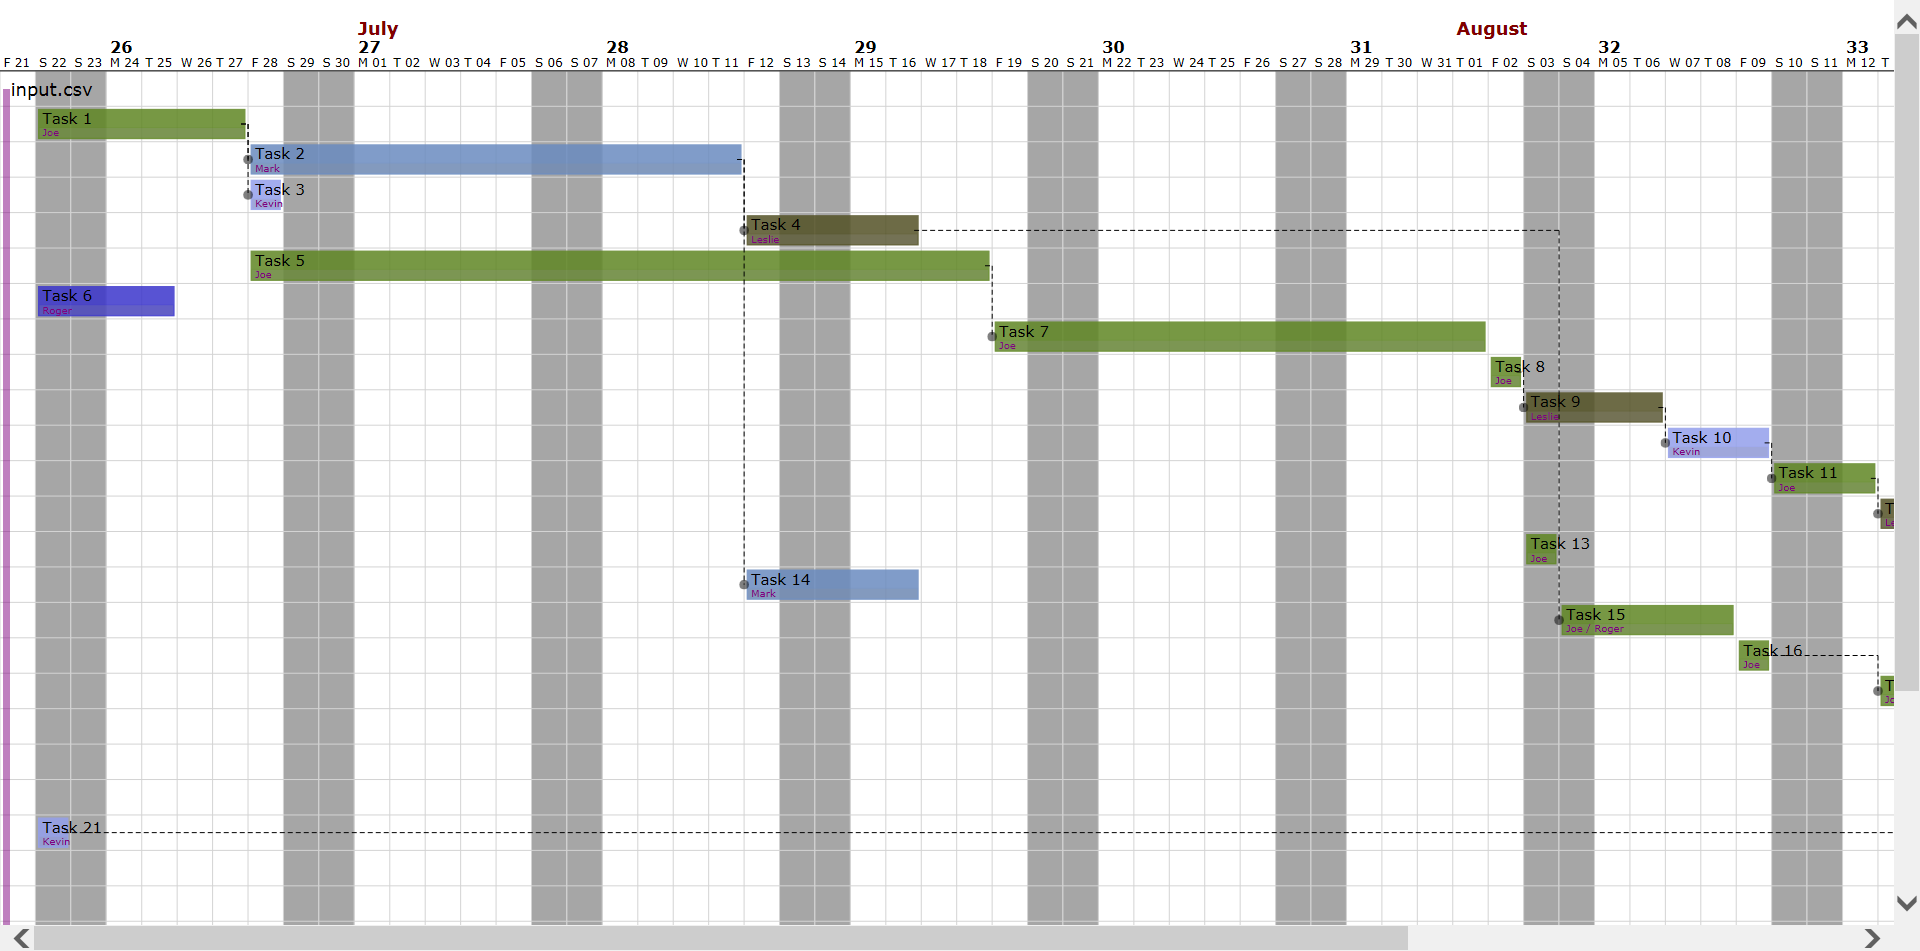

In [54]:
from IPython.display import Image
Image("check-sheet.png")